# Tensorflow2 KeyNotes
### ==== Time Series Analysis with Deep Neural Network (TF2) ====
### Instructions

These serial notebooks are intended to record my practicing and keynotes with deep learning in the framework of TensorFlow 2. Within these notebooks, I demonstrate the networks with specific examples and my personal interpretations.  You can find instructions in each section for each project.  Feel free to refer to it if is helpful for your work. 

In this notebook, I demonstrate a basic experiment of a time series analysis by using dense neural network, the following contents are included in this notebook: 

1. Time series generation
2. Time-frequency analysis of a time series by Fast Fourier Transform
2. Time series forecasting by using a dense neural network

### Code by Hao, Zhao, Aug, 2020.



### Import the tensorflow library

In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0



###  Load the external libraries

In [2]:
import numpy as np
# %matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.fftpack

from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense,BatchNormalization,Dropout,Conv1D


### Generate a synthetic time series based on sinusoid signals



In [3]:
dt,t_min,t_max = 0.001,0,20 
t              = np.linspace(t_min,t_max,int((t_max-t_min)/dt+1))
f0,f1,f2       = 30,100,200
SNR            = 20       
syn_sig        = np.sin((2*np.pi*f0)*t)  + np.sin((2*np.pi*f1)*t) + np.sin((2*np.pi*f2)*t)  
syn_data       = syn_sig + np.random.normal(0,10**(-SNR/20),len(syn_sig))


### Plot the generated time series

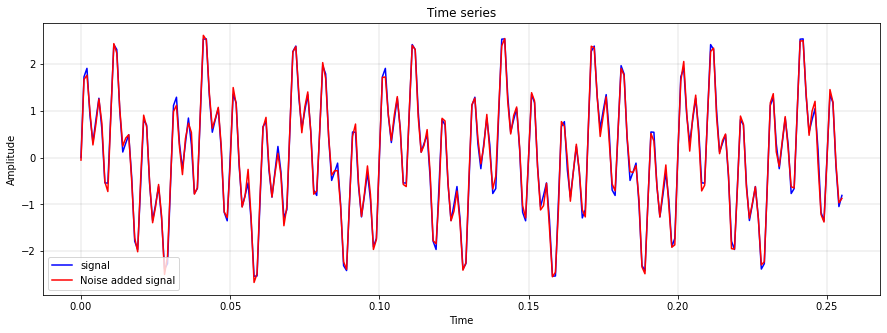

In [4]:

#set the samples to display
N=256

plt.figure(0,figsize=(15, 5))
plt.plot(t[0:N],syn_sig[0:N],'b',label='signal')
plt.plot(t[0:N],syn_data[0:N],'r',label='Noise added signal') 
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Time series')
plt.legend()
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.show()


### Time-frequency analysis of generated time series

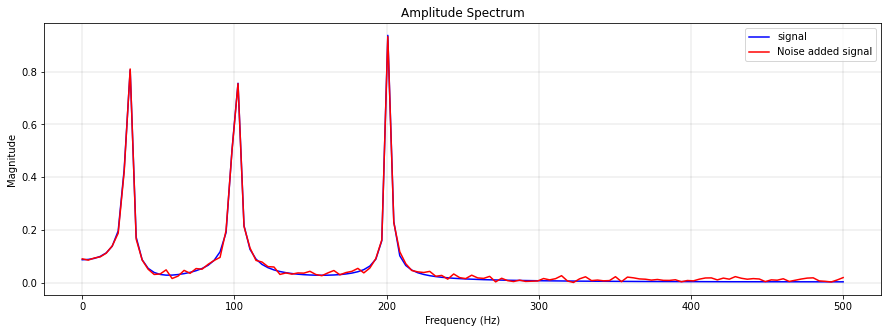

In [5]:
fft_syn_data = scipy.fftpack.fft(syn_data[0:N])
fft_syn_sig = scipy.fftpack.fft(syn_sig[0:N])

# 0 to Fs/2, Fs = 1/Ts
xf = np.linspace(0.0, 1.0/(2*dt), int(N/2))
plt.figure(1,figsize=(15, 5))
plt.plot(xf, 2.0/N * np.abs(fft_syn_sig[:N//2]),'b',label='signal')
plt.plot(xf, 2.0/N * np.abs(fft_syn_data[:N//2]),'r',label='Noise added signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Amplitude Spectrum')
plt.legend()
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.show()


### Dataset preprocessing to generate the training and testing datasets

In [6]:

# define the function for datasets generation 

def dataset_generation(time_series,batch_size,window_step,predict_step):
    
    # derive the total batch numbers
    n_batch = ((len(t))-batch_size)//window_step + 1
    
    # derive the datasets: input (x) and tartget (y)
    dataset_x     = []
    dataset_y     = []    
    train_set_x   = []
    train_set_y   = []
    test_set_x    = []
    test_set_y    = []
    
    # loop through the time series and gernerate the data
    for n in np.arange(1,n_batch+1):
        
        data_batch = time_series[(0+(n-1)*window_step):(batch_size+(n-1)*window_step)] 
        data_x     = data_batch[0:batch_size-predict_step]
        data_y     = data_batch[batch_size-predict_step:batch_size]
    
        dataset_x  = np.concatenate((dataset_x, data_x))
        dataset_y  = np.concatenate((dataset_y, data_y))
        
    # reshape datasets to 2d dimension: batch x dataset
    dataset_x = np.reshape(dataset_x, newshape=(n_batch,len(data_x)))
    dataset_y = np.reshape(dataset_y, newshape=(n_batch,len(data_y)))
    
    # split the dataset into train 80% and test sets (20%)
    train_samples  = int(len(dataset_x) * 0.8) 

    train_set_x = dataset_x[:train_samples,:]
    train_set_y = dataset_y[:train_samples,:]

    test_set_x  = dataset_x[train_samples:,:]
    test_set_y  = dataset_y[train_samples:,:] 
        
    return train_set_x,train_set_y,test_set_x,test_set_y
    

# generate the datasets 
batch_size   = 256
window_step  = batch_size//8
predict_step = 10

train_set_x,train_set_y,test_set_x,test_set_y = dataset_generation(syn_data,batch_size,window_step,predict_step)

print('train_set_x: has shape {}'.format(train_set_x.shape))
print('train_set_y: has shape {}'.format(train_set_y.shape))
print('test_set_x: has shape {}'.format(test_set_x.shape))
print('test_set_y: has shape {}'.format(test_set_y.shape))



train_set_x: has shape (494, 246)
train_set_y: has shape (494, 10)
test_set_x: has shape (124, 246)
test_set_y: has shape (124, 10)


### Build the dense neural network 

In [7]:
model = Sequential([Dense(32, activation='relu',input_shape=(batch_size-predict_step,)),
                    Dropout(0.1),
                    Dense(16,activation='relu'),
                    Dropout(0.1),
                    Dense(predict_step)
                    ])

model.compile(optimizer=tf.keras.optimizers.RMSprop(),loss='mse',metrics=['mae'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                7904      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                170       
Total params: 8,602
Trainable params: 8,602
Non-trainable params: 0
_________________________________________________________________


### Train the dense neural network

In [8]:
history = model.fit(train_set_x,train_set_y,epochs=300,validation_split=0.10,verbose=1)


Epoch 1/300
14/14 [==============================] - 0s 9ms/step - loss: 1.2934 - mae: 0.9153 - val_loss: 0.7635 - val_mae: 0.7111
Epoch 2/300
14/14 [==============================] - 0s 3ms/step - loss: 0.8473 - mae: 0.7414 - val_loss: 0.6009 - val_mae: 0.6288
Epoch 3/300
14/14 [==============================] - 0s 3ms/step - loss: 0.7240 - mae: 0.6798 - val_loss: 0.4979 - val_mae: 0.5593
Epoch 4/300
14/14 [==============================] - 0s 3ms/step - loss: 0.6357 - mae: 0.6279 - val_loss: 0.4253 - val_mae: 0.5075
Epoch 5/300
14/14 [==============================] - 0s 3ms/step - loss: 0.6075 - mae: 0.6122 - val_loss: 0.3848 - val_mae: 0.4860
Epoch 6/300
14/14 [==============================] - 0s 3ms/step - loss: 0.5581 - mae: 0.5810 - val_loss: 0.3294 - val_mae: 0.4498
Epoch 7/300
14/14 [==============================] - 0s 3ms/step - loss: 0.4992 - mae: 0.5487 - val_loss: 0.2801 - val_mae: 0.4143
Epoch 8/300
14/14 [==============================] - 0s 3ms/step - loss: 0.4752 - m

Epoch 63/300
14/14 [==============================] - 0s 3ms/step - loss: 0.1658 - mae: 0.2943 - val_loss: 0.0444 - val_mae: 0.1662
Epoch 64/300
14/14 [==============================] - 0s 3ms/step - loss: 0.1726 - mae: 0.2987 - val_loss: 0.0447 - val_mae: 0.1671
Epoch 65/300
14/14 [==============================] - 0s 3ms/step - loss: 0.1698 - mae: 0.2972 - val_loss: 0.0500 - val_mae: 0.1689
Epoch 66/300
14/14 [==============================] - 0s 3ms/step - loss: 0.1580 - mae: 0.2902 - val_loss: 0.0381 - val_mae: 0.1563
Epoch 67/300
14/14 [==============================] - 0s 3ms/step - loss: 0.1622 - mae: 0.2908 - val_loss: 0.0385 - val_mae: 0.1553
Epoch 68/300
14/14 [==============================] - 0s 3ms/step - loss: 0.1531 - mae: 0.2802 - val_loss: 0.0363 - val_mae: 0.1499
Epoch 69/300
14/14 [==============================] - 0s 3ms/step - loss: 0.1716 - mae: 0.2963 - val_loss: 0.0379 - val_mae: 0.1554
Epoch 70/300
14/14 [==============================] - 0s 3ms/step - loss: 0.

Epoch 125/300
14/14 [==============================] - 0s 3ms/step - loss: 0.1418 - mae: 0.2697 - val_loss: 0.0303 - val_mae: 0.1371
Epoch 126/300
14/14 [==============================] - 0s 3ms/step - loss: 0.1384 - mae: 0.2604 - val_loss: 0.0356 - val_mae: 0.1455
Epoch 127/300
14/14 [==============================] - 0s 3ms/step - loss: 0.1402 - mae: 0.2628 - val_loss: 0.0272 - val_mae: 0.1298
Epoch 128/300
14/14 [==============================] - 0s 3ms/step - loss: 0.1498 - mae: 0.2723 - val_loss: 0.0312 - val_mae: 0.1383
Epoch 129/300
14/14 [==============================] - 0s 3ms/step - loss: 0.1561 - mae: 0.2737 - val_loss: 0.0337 - val_mae: 0.1421
Epoch 130/300
14/14 [==============================] - 0s 3ms/step - loss: 0.1386 - mae: 0.2601 - val_loss: 0.0287 - val_mae: 0.1334
Epoch 131/300
14/14 [==============================] - 0s 3ms/step - loss: 0.1422 - mae: 0.2670 - val_loss: 0.0342 - val_mae: 0.1486
Epoch 132/300
14/14 [==============================] - 0s 3ms/step - 

14/14 [==============================] - 0s 3ms/step - loss: 0.1395 - mae: 0.2625 - val_loss: 0.0336 - val_mae: 0.1430
Epoch 187/300
14/14 [==============================] - 0s 3ms/step - loss: 0.1325 - mae: 0.2579 - val_loss: 0.0296 - val_mae: 0.1359
Epoch 188/300
14/14 [==============================] - 0s 3ms/step - loss: 0.1286 - mae: 0.2486 - val_loss: 0.0267 - val_mae: 0.1278
Epoch 189/300
14/14 [==============================] - 0s 3ms/step - loss: 0.1147 - mae: 0.2337 - val_loss: 0.0281 - val_mae: 0.1325
Epoch 190/300
14/14 [==============================] - 0s 3ms/step - loss: 0.1168 - mae: 0.2380 - val_loss: 0.0306 - val_mae: 0.1378
Epoch 191/300
14/14 [==============================] - 0s 3ms/step - loss: 0.1265 - mae: 0.2497 - val_loss: 0.0243 - val_mae: 0.1248
Epoch 192/300
14/14 [==============================] - 0s 3ms/step - loss: 0.1315 - mae: 0.2561 - val_loss: 0.0279 - val_mae: 0.1358
Epoch 193/300
14/14 [==============================] - 0s 3ms/step - loss: 0.1347 -

Epoch 248/300
14/14 [==============================] - 0s 3ms/step - loss: 0.1302 - mae: 0.2510 - val_loss: 0.0305 - val_mae: 0.1346
Epoch 249/300
14/14 [==============================] - 0s 3ms/step - loss: 0.1414 - mae: 0.2551 - val_loss: 0.0270 - val_mae: 0.1267
Epoch 250/300
14/14 [==============================] - 0s 3ms/step - loss: 0.1226 - mae: 0.2454 - val_loss: 0.0218 - val_mae: 0.1173
Epoch 251/300
14/14 [==============================] - 0s 3ms/step - loss: 0.1326 - mae: 0.2557 - val_loss: 0.0235 - val_mae: 0.1204
Epoch 252/300
14/14 [==============================] - 0s 3ms/step - loss: 0.1321 - mae: 0.2575 - val_loss: 0.0209 - val_mae: 0.1143
Epoch 253/300
14/14 [==============================] - 0s 3ms/step - loss: 0.1422 - mae: 0.2628 - val_loss: 0.0247 - val_mae: 0.1256
Epoch 254/300
14/14 [==============================] - 0s 3ms/step - loss: 0.1263 - mae: 0.2421 - val_loss: 0.0268 - val_mae: 0.1292
Epoch 255/300
14/14 [==============================] - 0s 3ms/step - 

# Display of training and validation losses in the network training


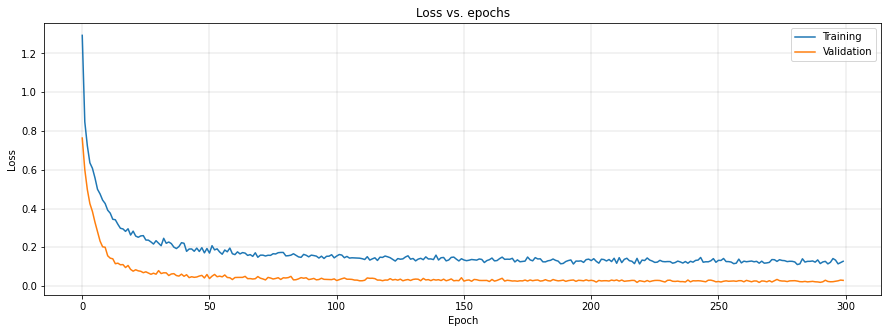

In [9]:
plt.figure(2,figsize=(15, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.show()


### Time series forecasting with trainned dense neural network


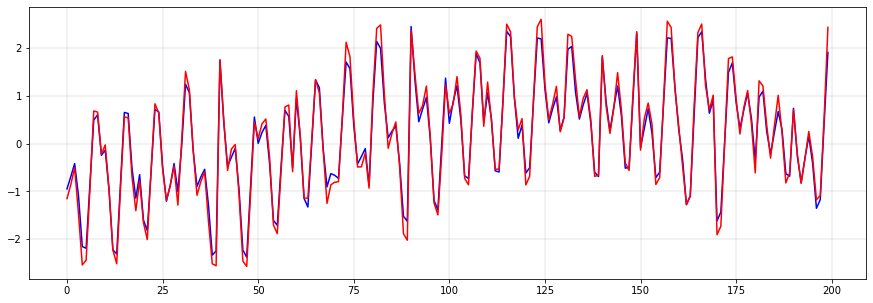

====== Signal to Noise ratio of the prediction based on dense neural network: 17.455367002077267
====== Mean Square Error of the prediction based on dense neural network: 0.02704699190744104


In [10]:
dnn_predictions = model.predict(test_set_x)
dnn_err         = dnn_predictions - test_set_y

plt.figure(3,figsize=(15, 5))
plt.plot(dnn_predictions[:20,:].flatten(),'b')
plt.plot(test_set_y[:20,:].flatten(),'r')
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.show()

dnn_mse    = 10*np.log10(np.mean(pow(np.abs(dnn_err),2)))
dnn_sigpow = 10*np.log10(np.mean(pow(np.abs(test_set_y),2)))


print("====== Signal to Noise ratio of the prediction based on dense neural network:", dnn_sigpow - dnn_mse)
print("====== Mean Square Error of the prediction based on dense neural network:", np.mean(tf.keras.losses.mean_squared_error(dnn_predictions,test_set_y)))
